In [ ]:
!python train.py --data data/dataset/custom.data --cfg cfg/yolov3-custom.cfg --batch 10 --cache --epochs 500 --nosave

Namespace(epochs=500, batch_size=10, accumulate=4, cfg='cfg/yolov3-custom.cfg', data='data/dataset/custom.data', multi_scale=False, img_size=[512], rect=False, resume=False, nosave=True, notest=False, evolve=False, bucket='', cache_images=True, weights='weights/yolov3-spp-ultralytics.pt', name='', device='', adam=False, single_cls=False)
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15102MB)

2024-04-21 19:08:02.077970: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 19:08:02.078031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 19:08:02.079523: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory

In [ ]:
pwd


'/content'

In [ ]:
def convert_backslash_to_forwardslash(input_file, output_file):
    with open(input_file, 'r') as f_in:
        content = f_in.read()

    modified_content = content.replace('\\', '/')

    with open(output_file, 'w') as f_out:
        f_out.write(modified_content)

# Example usage:
input_file = '/content/drive/MyDrive/tsai_yolo/YoloV3-master/data/dataset/train.txt'
output_file = '/content/drive/MyDrive/tsai_yolo/YoloV3-master/data/dataset/train.txt'

convert_backslash_to_forwardslash(input_file, output_file)


In [ ]:
pwd

'/content'

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
cd drive/MyDrive

/content/drive/MyDrive


In [2]:
cd /content/drive/MyDrive/tsai_yolo/YoloV3-master

/content/drive/MyDrive/tsai_yolo/YoloV3-master


In [ ]:
sce = "/content/drive/MyDrive/tsai_yolo/YoloV3-master/data/dataset/test"
congif = "/content/drive/MyDrive/tsai_yolo/YoloV3-master/cfg/yolov3-custom.cfg"
outp = "/content/drive/MyDrive/tsai_yolo/YoloV3-master/Untitled Folder"

In [4]:
!python detect.py --cfg "/content/drive/MyDrive/tsai_yolo/YoloV3-master/cfg/yolov3-custom.cfg" --source data/dataset/images/0025.jpg --output /content/drive/MyDrive/tsai_yolo/YoloV3-master/ress

Namespace(cfg='/content/drive/MyDrive/tsai_yolo/YoloV3-master/cfg/yolov3-custom.cfg', names='data/customdata/custom.names', weights='weights/last.pt', source='data/dataset/images/0025.jpg', output='/content/drive/MyDrive/tsai_yolo/YoloV3-master/ress', img_size=512, conf_thres=0.3, iou_thres=0.6, fourcc='mp4v', half=False, device='', view_img=False, save_txt=False, classes=None, agnostic_nms=False, augment=False)
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15102MB)

Model Summary: 225 layers, 6.25787e+07 parameters, 6.25787e+07 gradients
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
image 1/1 data/dataset/images/0025.jpg: Traceback (most recent call last):
  File "/content/drive/MyDrive/tsai_yolo/Yo

In [10]:
device = torch.device('cuda')

In [6]:
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114)):
    # Resize and pad image while preserving aspect ratio
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Compute the new size preserving aspect ratio
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    ratio = r, r
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))

    # Resize with aspect ratio preservation
    dw = new_shape[1] - new_unpad[0]  # width padding
    dh = new_shape[0] - new_unpad[1]  # height padding
    top, bottom = dh // 2, dh - (dh // 2)
    left, right = dw // 2, dw - (dw // 2)

    # Apply padding
    img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return img, ratio, (dw, dh)


Model Summary: 225 layers, 6.25787e+07 parameters, 6.25787e+07 gradients


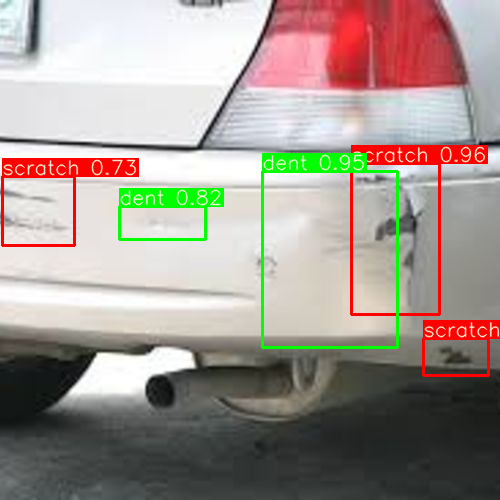

In [21]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

from models import *
from utils.utils import *

# Define the function for object detection
def detect(model, img_path, img_size=512, conf_thres=0.3, iou_thres=0.6, device=''):
    # Load image
    img0 = cv2.imread(img_path)  # BGR
    img = letterbox(img0, new_shape=img_size)[0]

    # Normalize image
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, HWC to CHW
    img = np.ascontiguousarray(img)

    # Convert image to tensor
    device = torch.device('cuda')
    img = torch.from_numpy(img).to(device)
    img = img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0

    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    # Inference
    pred = model(img)[0]

    # Apply NMS
    pred = non_max_suppression(pred, conf_thres, iou_thres)

    names = ['dent', 'scratch']
    colors = [(0,255,0),(0,0,255)]
    # Process detections
    for i, det in enumerate(pred):  # detections per image
        if det is not None and len(det):
            # Rescale boxes from 416 to image size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()

            # Draw bounding boxes and labels
            for *xyxy, conf, cls in det:
                label = f'{names[int(cls)]} {conf:.2f}'
                plot_one_box(xyxy, img0, label=label, color=colors[int(cls)])

    return img0

# Paths
weights_path = 'weights/last.pt'  # Path to your trained weights
img_path = '/content/drive/MyDrive/tsai_yolo/YoloV3-master/data/dataset/images/0025.jpg'  # Path to your test image

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Darknet(cfg='cfg/yolov3-custom.cfg', img_size=512)
model.load_state_dict(torch.load(weights_path, map_location=device)['model'])
model.to(device).eval()

# Run detection
output_image = detect(model, img_path)

# Display the output image
cv2_imshow(output_image)
